Time for all 9 sims =  7.202982187271118 s
best fit g = 0.003575000000041178 best fit theta = 9.639160837867031


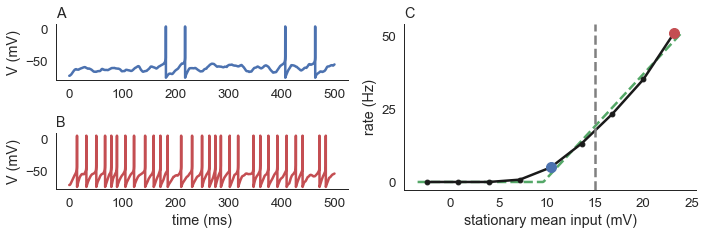

In [1]:
###############################################
## Import packages and specify some settings ##
###############################################
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This makes plots show up and look nice
%matplotlib inline
sns.set(context='paper',style='white',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.set_palette('muted')

###############################################
###############################################

# For computing runtimes
from time import time as tm

# Seed random number generator so that
# we get the same results every time
# we run this code
np.random.seed(1)

# Make figure
plt.subplots(figsize=(10, 3.5))

# Create a vector of exc rates and
# initialize a vector for postsynaptic rates
res=np.arange(3,12,1)/1000
replot1Ind=4
replot2Ind=8
rs=np.zeros_like(res)
IBars=np.zeros_like(res)
t0=tm()
for k in range(len(res)):

    # Discretized time
    T=5000
    dt=.1 
    time=np.arange(0,T,dt)

    # Presynaptic inh rate
    ri=15/1000
    re=res[k]

    # Number of exc and inh presynaptic neurons
    Ke=200
    Ki=50

    # Synapse parameters
    Je=16+np.zeros(Ke)
    Ji=-16+np.zeros(Ki)
    taue=5
    taui=5

    # Stationary mean of Ie and Ii 
    # from mean-field theory
    IeBar=Ke*np.mean(Je)*re
    IiBar=Ki*np.mean(Ji)*ri


    # Neuron parameters
    EL=-72 
    taum=10
    Vth=5
    Vre=-75
    VT=-55
    D=2

    # Generate spike densities
    Se=np.random.poisson(re*dt,(Ke,len(time)))/dt
    Si=np.random.poisson(ri*dt,(Ki,len(time)))/dt


    # Euler solver to compute Is and V
    Ie=np.zeros_like(time)
    Ii=np.zeros_like(time)
    V=np.zeros_like(time)
    PostSpikeTimes=[]
    V[0]=EL
    for i in range(len(time)-1):

        # Euler step
        V[i+1]=V[i]+dt*(-(V[i]-EL)+D*np.exp((V[i]-VT)/D)+Ie[i]+Ii[i])/taum    
        Ie[i+1]=Ie[i]+dt*(-Ie[i]+Je@Se[:,i])/taue
        Ii[i+1]=Ii[i]+dt*(-Ii[i]+Ji@Si[:,i])/taui

        # Threshold-reset condition
        if V[i+1]>=Vth:
            V[i+1]=Vre 
            V[i]=Vth  # This makes plots nicer
            PostSpikeTimes=np.append(PostSpikeTimes,time[i+1])        


    # Stationary mean membrane potential of a leaky integrator
    IBars[k]=IeBar+IiBar
    rs[k]=len(PostSpikeTimes)/T
    
    if(k==replot1Ind):
        plt.subplot(2,2,1)
        plt.plot(time[:5000],V[:5000],'b')
        plt.ylabel('V (mV)')
        plt.title('A',loc='left')
        sns.despine()
    if(k==replot2Ind):
        plt.subplot(2,2,3)
        plt.plot(time[:5000],V[:5000],'r')
        plt.xlabel('time (ms)')
        plt.ylabel('V (mV)')
        plt.title('B',loc='left')
        sns.despine()        
    
    
print('Time for all',len(res),'sims = ',tm()-t0,'s')    

# Threshold input
Ith=VT-D-EL

# Fit an f-I curve to the data from simulation
from scipy.optimize import curve_fit
def f(IBar, g, theta):
    return g*(IBar-theta)*(IBar>theta)
params,_=curve_fit(f, IBars, rs)
gfit=params[0]
thetafit=params[1]
print('best fit g =',gfit,'best fit theta =',thetafit)


# Raster plot
plt.subplot(1,2,2)
Iplot=np.arange(np.min(IBars)-1,np.max(IBars)+1,.1)
plt.plot(Iplot,1000*f(Iplot,gfit,thetafit),'g--')
plt.plot(IBars,1000*rs,'k-o')
plt.plot(IBars[replot1Ind],1000*rs[replot1Ind],'b.',markersize=20)
plt.plot(IBars[replot2Ind],1000*rs[replot2Ind],'r.',markersize=20)
plt.axvline(Ith,color='gray',linestyle='dashed')
plt.yticks([0,25,50])
plt.xlabel('stationary mean input (mV)')
plt.ylabel('rate (Hz)')
plt.title('C',loc='left')
sns.despine()


plt.tight_layout()

